In [3]:
import time
import json
import numpy as np
import pandas as pd
import ringity as rng
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
import ringity.generators.geometric_networks as rgeom
from ringity.readwrite.pdiagrams import json_to_dictofdictoflist, data_to_json

from pathlib import Path
from itertools import product
from collections import defaultdict
from scipy.spatial.distance import pdist

In [4]:
METRICS = ['spl', 'current_flow', 'resistance', 'betweenness']
PALETTE = sns.color_palette(n_colors = len(METRICS))

In [6]:
def update_data_dict(network_generator, 
                     network_params, 
                     var_param, 
                     geometric):
    while True:
        G, X = network_generator(**network_params,
                                 return_point_cloud = geometric)
        if nx.is_connected(G):
            break
        
    for metric in set(METRICS) - {'X'}:
        pdgm = rng.pdiagram_from_network(G, metric = metric)
        data_dict[metric][var_param].append(pdgm)
        
    if geometric:
        pdgm_X = rng.pdiagram_from_point_cloud(X)
        data_dict['X'][var_param].append(pdgm_X)

---

In [7]:
X_color = sns.color_palette('dark', n_colors = 8)[-1]

## Noisy circle - robusnes on node level: $\sigma \approx 1-c$

### Setup

In [8]:
# Network parameters
N = 2**7
er_fc_th = 10
var_param_name = 'noise'

In [10]:
fname_data = Path(f'../../../data/pdgms_circles_N{N}_ERFC{er_fc_th}.json')
data_dict = json_to_dictofdictoflist(fname_data)

### Calculations

In [12]:
# Calculation parameters
nb_noises = 2**5
nb_var_param = 2**4
nb_samples = 2**2

var_params = np.linspace(0, 1, nb_var_param).round(6)
samples = range(nb_samples)

In [13]:
network_generator = rgeom.circle
network_params = {'N' : N, 'er_fc_th' : er_fc_th}
geometric = True

In [25]:
t1 = time.time()

nb_loops = sum(1 for _ in product(var_params, samples))
for nr, (var_param, _) in enumerate(product(var_params, samples)):
    network_params[var_param_name] = var_param
    update_data_dict(network_generator, 
                     network_params, 
                     var_param, 
                     geometric)
            
    t2 = time.time()
    p = (nr+1)/nb_loops
    diff = t2-t1
    print(f'progress: {100*p:.2f}% - {diff:.2f}sec; eta: {diff*(1/p - 1):.2f}sec', end = '\r')

In [26]:
data_to_json(data_dict)

### Visualizations

In [14]:
to_concatinate = []
for metric, data in data_dict.items():
    for noise, pdgms in data.items():
        scores = [pdgm.ring_score('gap') for pdgm in pdgms]
        df_metric_chunk = pd.DataFrame({'scores' : scores,
                                        'metric' : metric,
                                        'noise' : noise})
        to_concatinate.append(df_metric_chunk)
        
data_df = pd.concat(to_concatinate, ignore_index = True)

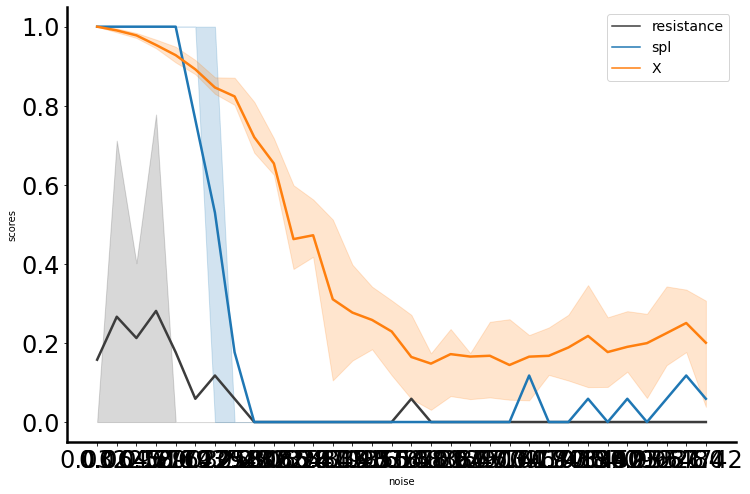

In [15]:
fig, ax = plt.subplots(figsize = (12,8))

plot_data = data_df[data_df.metric.isin({'X', 'spl', 'resistance'})]
# plot_data = data_df

ax = sns.lineplot(data = plot_data, 
                  x = 'noise', 
                  y = 'scores', 
                  hue = 'metric', 
                  linewidth = 2.5,
                  errorbar = ('pi', 50),
                  palette = [X_color] + PALETTE[0:2],
                  ax = ax)

rng.plotting.styling.ax_setup(ax)

leg = ax.legend(fontsize = 14)

# fig.savefig('plots/direct_metrics_noisy_circle.png')
# fig.savefig('plots/direct_metrics_noisy_circle.pdf')

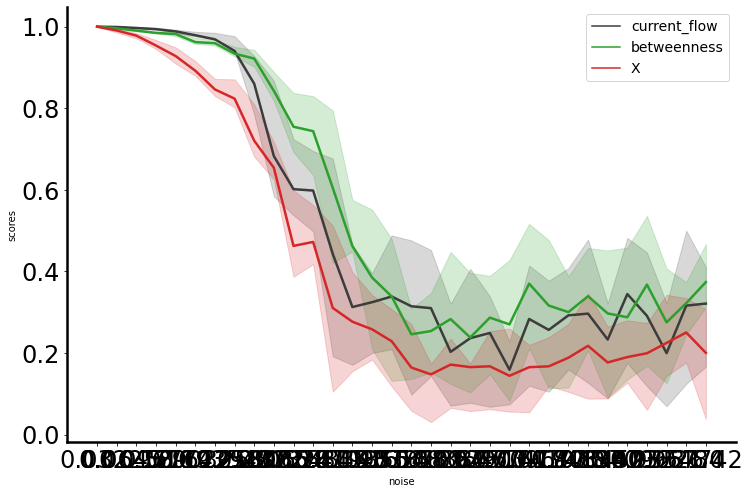

In [16]:
fig, ax = plt.subplots(figsize = (12,8))

plot_data = data_df[data_df.metric.isin({'X', 'current_flow', 'betweenness'})]
# plot_data = data_df

ax = sns.lineplot(data = plot_data, 
                  x = 'noise', 
                  y = 'scores', 
                  hue = 'metric', 
                  linewidth = 2.5,
                  errorbar = ('pi', 50),
                  palette = [X_color] + PALETTE[2:4],
                  ax = ax)

rng.plotting.styling.ax_setup(ax)

leg = ax.legend(fontsize = 14)

# fig.savefig('plots/centrality_metrics_noisy_circle.png')
# fig.savefig('plots/centrality_metrics_noisy_circle.pdf')

## Von Mises circle - robusnes on sparse regions: $\kappa \approx 1-\beta$

---

## Watts-Strogatz - robustnes on edge-level

In [3]:
# Network parameters
N = 1000
k = 10

### Calculations

In [8]:
# Calculation parameters
nb_betas = 2**1
nb_samples = 2**1

In [11]:
betas = np.logspace(-4, 0, nb_betas).round(6)
samples = range(nb_samples)

fname_data = Path(f'../../../data/pdgms_WS(N{N}, k{k}).json')
data_dict = json_to_dictofdictoflist(fname_data)

In [ ]:
betas = [key for key in data_dict['spl'] if len(data_dict['spl'][key]) < 42]

# Initialize data_dict
t1 = time.time()

nb_loops = sum(1 for _ in product(betas, samples))
for nr, (beta, _) in enumerate(product(betas, samples)):
    if len(data_dict['spl'][beta]) > 42:
        continue
    while True:
        G = nx.watts_strogatz_graph(N, k, beta)
        if nx.is_connected(G):
            break
    
    for metric in METRICS:
        pdgm = rng.pdiagram_from_network(G, metric = metric)
        data_dict[metric][beta].append(pdgm)
            
    t2 = time.time()
    p = (nr+1)/nb_loops
    diff = t2-t1
    print(f'progress: {100*p:.2f}% - {diff:.2f}sec; eta: {diff*(1/p - 1):.2f}sec', end = '\r')

In [ ]:
# Initialize data_dict
data_dict = defaultdict(lambda: defaultdict(list))
t1 = time.time()

nb_loops = sum(1 for _ in product(betas, samples))
for nr, (beta, _) in enumerate(product(betas, samples)):
    while True:
        G = nx.watts_strogatz_graph(N, k, beta)
        if nx.is_connected(G):
            break
    
    for metric in METRICS:
        pdgm = rng.pdiagram_from_network(G, metric = metric)
        data_dict[metric][beta].append(pdgm)
            
    t2 = time.time()
    p = (nr+1)/nb_loops
    diff = t2-t1
    print(f'progress: {100*p:.2f}% - {diff:.2f}sec; eta: {diff*(1/p - 1):.2f}sec', end = '\r')

In [28]:
data_to_json(data_dict)

In [11]:
for metric in list(data_dict.keys()):
    for key in list(data_dict[metric].keys()):
        if len(data_dict[metric][key]) < 30:
            del data_dict[metric][key]

### Visualization

In [24]:
to_concatinate = []
for metric, data in data_dict.items():
    for noise, pdgms in data.items():
        scores = [pdgm.ring_score('gap') for pdgm in pdgms]
        df_metric_chunk = pd.DataFrame({'scores' : scores,
                                        'metric' : metric,
                                        'noise' : noise})
        to_concatinate.append(df_metric_chunk)
        
data_df = pd.concat(to_concatinate, ignore_index = True)

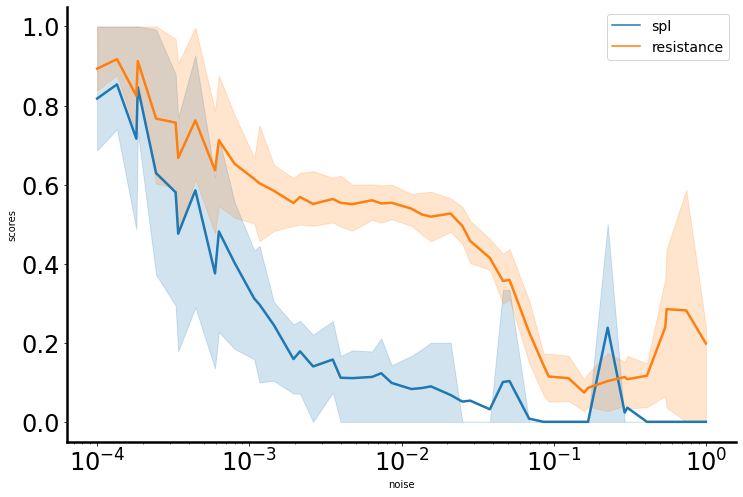

In [25]:
fig, ax = plt.subplots(figsize = (12,8))

plot_data = data_df[data_df.metric.isin({'spl', 'resistance'})]
# plot_data = data_df

ax = sns.lineplot(data = plot_data, 
                  x = 'noise', 
                  y = 'scores', 
                  hue = 'metric', 
                  linewidth = 2.5,
                  errorbar = ('pi', 50),
                  palette = PALETTE[:2],
                  ax = ax)
ax.set(xscale = 'log')
rng.plotting.styling.ax_setup(ax)

leg = ax.legend(fontsize = 14)

# fig.savefig('plots/direct_metrics_noisy_circle.png')
# fig.savefig('plots/direct_metrics_noisy_circle.pdf')

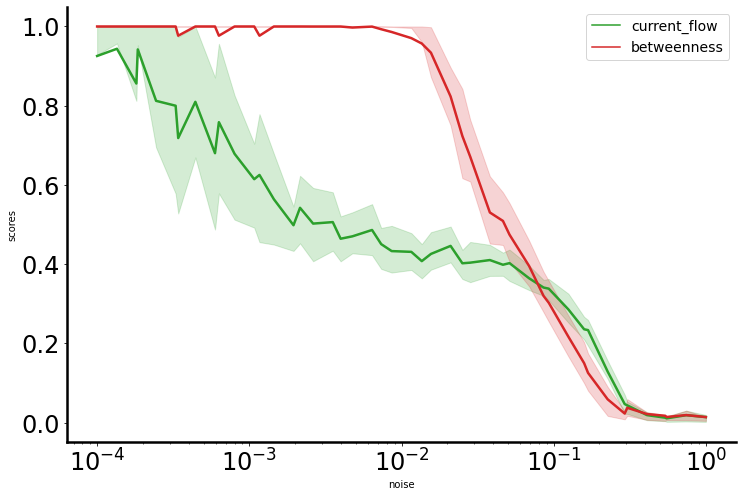

In [26]:
fig, ax = plt.subplots(figsize = (12,8))

plot_data = data_df[data_df.metric.isin({'current_flow', 'betweenness'})]
# plot_data = data_df

ax = sns.lineplot(data = plot_data, 
                  x = 'noise', 
                  y = 'scores', 
                  hue = 'metric', 
                  linewidth = 2.5,
                  errorbar = ('pi', 50),
                  palette = PALETTE[2:4],
                  ax = ax)
ax.set(xscale = 'log')
rng.plotting.styling.ax_setup(ax)

leg = ax.legend(fontsize = 14)

# fig.savefig('plots/centrality_metrics_noisy_circle.png')
# fig.savefig('plots/centrality_metrics_noisy_circle.pdf')

### Annulus

In [3]:
N = 2**8
abs_th = 0.5

nb_radii = 2**4
nb_samples = 2**3

metrics = ['spl', 'current_flow', 'resistance', 'betweenness']
score_df = pd.DataFrame(columns = metrics + ['X'])

radii = np.linspace(0, 1, nb_radii)
samples = range(nb_samples)

# Initialize data_dict
data_dict = defaultdict(lambda: defaultdict(list))
t1 = time.time()

nb_loops = sum(1 for _ in product(radii, samples))
for nr, (r_in, _) in enumerate(product(radii, samples)):
    G, X = rgeom.annulus(N, r_in, abs_th = abs_th, return_point_cloud = True)
    
    pdgm_X = rng.pdiagram_from_point_cloud(X)
    data_dict['X'][r_in].append(pdgm_X)
        
    for metric in metrics:
        pdgm = rng.pdiagram_from_network(G, metric = metric)
        data_dict[metric][r_in].append(pdgm)
        
        if len(pdgm) == 0:
            print('wow')
            
    t2 = time.time()
    p = (nr+1)/nb_loops
    diff = t2-t1
    print(f'progress: {100*p:.2f}% - {diff:.2f}sec; eta: {diff*(1/p - 1):.2f}sec', end = '\r')

In [8]:
to_concatinate = []
for metric, data in data_dict.items():
    for r_inner, pdgms in data.items():
        scores = [1-get_second(pdgm) for pdgm in pdgms]
        df_metric_chunk = pd.DataFrame({'scores' : scores,
                                        'metric' : metric,
                                        'inner_radius' : r_inner})
        to_concatinate.append(df_metric_chunk)
        
data_df = pd.concat(to_concatinate, ignore_index = True)

/Users/markusyoussef/Documents/coding/venvs/ringity/lib/python3.9/site-packages/ringity/classes/pdiagram.py:230: RuntimeWarning: invalid value encountered in divide
  return pseq/self.signal


In [11]:
to_concatinate = []
for metric, data in data_dict.items():
    for r_inner, pdgms in data.items():
        scores = [pdgm.ring_score() for pdgm in pdgms]
        df_metric_chunk = pd.DataFrame({'scores' : scores,
                                        'metric' : metric,
                                        'inner_radius' : r_inner})
        to_concatinate.append(df_metric_chunk)
        
data_df = pd.concat(to_concatinate, ignore_index = True)

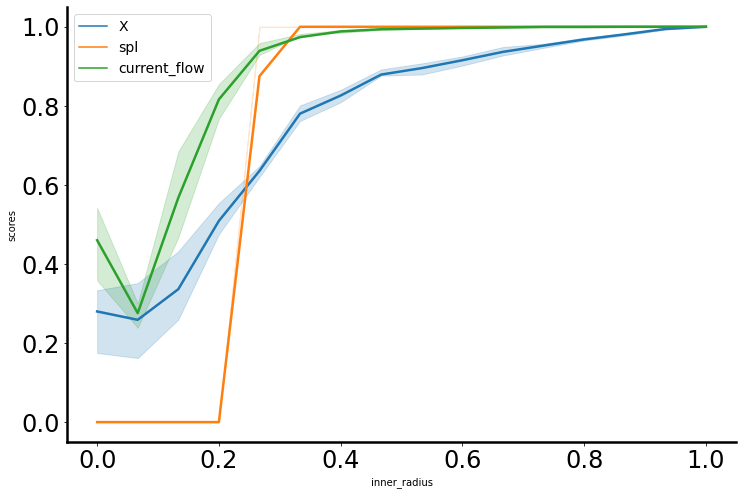

In [13]:
fig, ax = plt.subplots(figsize = (12,8))

plot_data = data_df[data_df.metric.isin({'X', 'spl', 'current_flow'})]
# plot_data = data_df
ax = sns.lineplot(data = plot_data, 
                  x = 'inner_radius', 
                  y = 'scores', 
                  hue = 'metric', 
                  linewidth = 2.5,
                  errorbar = ('pi', 50),
                  ax = ax)

rng.plotting.styling.ax_setup(ax)

leg = ax.legend(fontsize = 14)

In [5]:
row_data = []
for metric, data in data_dict.items():
    for r_i, pdgms in data.items():
        row_data.append({'metric' : metric})
        scores = [pdgm.ring_score() for pdgm in pdgms]

        row_data[-1]['inner_radius'] = r_i

        row_data[-1]['avg_scores'] = np.mean(scores)
        row_data[-1]['lqt_scores'] = np.percentile(scores, 25)
        row_data[-1]['uqt_scores'] = np.percentile(scores, 75)
        
data_df = pd.DataFrame(row_data)

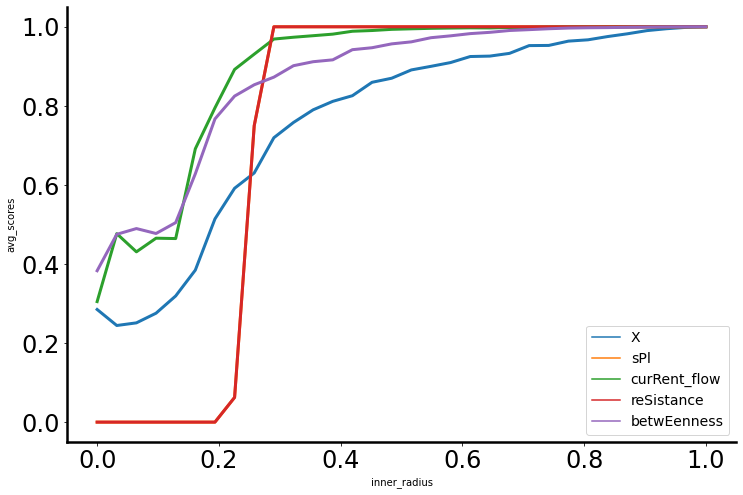

In [7]:
fig, ax = plt.subplots(figsize = (12,8))

ax = sns.lineplot(data = data_df, 
                  x = 'inner_radius', 
                  y = 'avg_scores', 
                  hue = 'metric', 
                  linewidth = 3,
                  ax = ax)

rng.plotting.styling.ax_setup(ax)

leg = ax.legend(fontsize = 14)

### Cylinder

In [47]:
N = 2**8
abs_th = 1
h_max = 10

nb_heights = 2**4
nb_samples = 2**3

metrics = ['spl', 'current_flow', 'resistance', 'betweenness']
score_df = pd.DataFrame(columns = metrics + ['X'])

heights = np.linspace(0, h_max, nb_heights)
samples = range(nb_samples)

# Initialize data_dict
data_dict = defaultdict(lambda: defaultdict(list))
t1 = time.time()

nb_loops = sum(1 for _ in product(heights, samples))
for nr, (height, _) in enumerate(product(heights, samples)):
    while True:
        G, X = rgeom.cylinder(int(N * (1+height/h_max)), 
                              height = height, 
                              abs_th = abs_th, 
                              return_point_cloud = True)
        if nx.is_connected(G):
            break
    
    pdgm_X = rng.pdiagram_from_point_cloud(X)
    data_dict['X'][height].append(pdgm_X)
        
    for metric in metrics:
        pdgm = rng.pdiagram_from_network(G, metric = metric)
        data_dict[metric][height].append(pdgm)
        
        if len(pdgm) == 0:
            print('wow')
            
    t2 = time.time()
    p = (nr+1)/nb_loops
    diff = t2-t1
    print(f'progress: {100*p:.2f}% - {diff:.2f}sec; eta: {diff*(1/p - 1):.2f}sec', end = '\r')

In [49]:
def get_second(pdgm):
    try:
        return pdgm.psequence('signal')[1]
    except IndexError:
        return 0

In [50]:
to_concatinate = []
for metric, data in data_dict.items():
    for height, pdgms in data.items():
        scores = [1-get_second(pdgm) for pdgm in pdgms]
        df_metric_chunk = pd.DataFrame({'scores' : scores,
                                        'metric' : metric,
                                        'height' : height})
        to_concatinate.append(df_metric_chunk)
        
data_df = pd.concat(to_concatinate, ignore_index = True)

/Users/markusyoussef/Documents/coding/venvs/ringity/lib/python3.9/site-packages/ringity/classes/pdiagram.py:213: RuntimeWarning: invalid value encountered in divide
  return pseq/self.signal


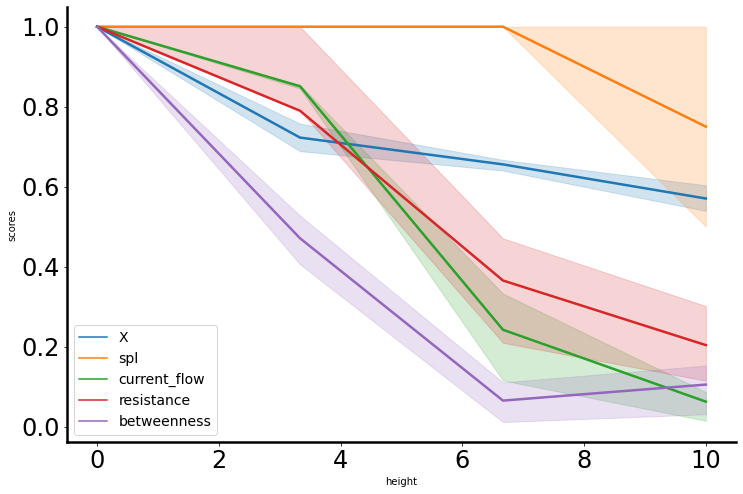

In [52]:
fig, ax = plt.subplots(figsize = (12,8))

plot_data = data_df[data_df.metric.isin({'X', 'spl', 'current_flow'})]
plot_data = data_df
ax = sns.lineplot(data = plot_data, 
                  x = 'height', 
                  y = 'scores', 
                  hue = 'metric', 
                  linewidth = 2.5,
                  errorbar = ('pi', 50),
                  ax = ax)

rng.plotting.styling.ax_setup(ax)

leg = ax.legend(fontsize = 14)